In [34]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import seaborn as sns
import os

from sklearn.datasets import fetch_covtype
import torchvision
import torchvision.transforms as transforms
import torch

from sklearn.neural_network import MLPClassifier
import time
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tqdm
from baselineClassifierNN import SimpleMLP
from DynamicClassifierNN import DynamicMLP

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from itertools import product
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
rcParams['axes.labelsize'] = 12  # Academic font size for axis labels
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['axes.titlesize'] = 14
figsize = (8, 6) 

In [3]:
data_dir = "../data"
results_dir = "../results"

# Get datasets section

### Covtype dataset

In [4]:
data_cov = fetch_covtype(as_frame=True)
df_covtype = data_cov.frame 

df_covtype['Cover_Type'] = df_covtype['Cover_Type'] - 1
df_covtype['Aspect_sin'] = np.sin(np.deg2rad(df_covtype['Aspect']))
df_covtype['Aspect_cos'] = np.cos(np.deg2rad(df_covtype['Aspect']))
df_covtype = df_covtype.drop(columns=['Aspect'])


X_cov_type = df_covtype.drop('Cover_Type', axis=1).values
y_cov_type = df_covtype['Cover_Type'].values

print("Covtype dataset loaded.")
print(f"Covtype features shape: {X_cov_type.shape}, Covtype labels shape: {y_cov_type.shape}")

Covtype dataset loaded.
Covtype features shape: (581012, 55), Covtype labels shape: (581012,)


In [5]:
df_covtype.head()

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,...,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type,Aspect_sin,Aspect_cos
0,2596.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.777146,0.629320
1,2590.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.829038,0.559193
2,2804.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.656059,-0.754710
3,2785.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.422618,-0.906308
4,2595.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.707107,0.707107


### Fashion-MNIST dataset

In [6]:

# Download and load Fashion-MNIST
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True,  
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Convert train_dataset to DataFrame
train_images = []
train_labels = []

for img, label in train_dataset:
    train_images.append(img.numpy().flatten())
    train_labels.append(label)

df_train_fashion = pd.DataFrame(train_images)
df_train_fashion['label'] = train_labels

# Convert test_dataset to DataFrame
test_images = []
test_labels = []

for img, label in test_dataset:
    test_images.append(img.numpy().flatten())
    test_labels.append(label)

df_test_fashion = pd.DataFrame(test_images)
df_test_fashion['label'] = test_labels

print("Fashion-MNIST dataset loaded.")
print(f"Fashion-MNIST train shape: {df_train_fashion.shape}, Fashion-MNIST test shape: {df_test_fashion.shape}")
df_train_fashion.head()


Fashion-MNIST dataset loaded.
Fashion-MNIST train shape: (60000, 785), Fashion-MNIST test shape: (10000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,...,0.447059,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.000000,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
# what is the class distribution for each dataset
print("Covtype class distribution:\n", pd.Series(y_cov_type).value_counts().sort_index())
print("Fashion-MNIST class distribution:\n", pd.Series(df_train_fashion['label']).value_counts().sort_index())

Covtype class distribution:
 0    211840
1    283301
2     35754
3      2747
4      9493
5     17367
6     20510
Name: count, dtype: int64
Fashion-MNIST class distribution:
 label
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64


In [8]:
# take away 1000 entries from class label 0 in fashion mnist
for i in range(0, 10):
    index_to_drop = df_train_fashion[df_train_fashion['label'] == i].index[0]
    df_train_fashion = df_train_fashion.drop(df_train_fashion[df_train_fashion['label'] == i].index[:500*i])
print("Updated Fashion-MNIST class distribution:\n", pd.Series(df_train_fashion['label']).value_counts().sort_index())

Updated Fashion-MNIST class distribution:
 label
0    6000
1    5500
2    5000
3    4500
4    4000
5    3500
6    3000
7    2500
8    2000
9    1500
Name: count, dtype: int64


### Prepare each dataset for training and testing

### Covtype dataset

In [ ]:

X_train_cov_init, X_test_cov_init, y_train_cov_init, y_test_cov_init = train_test_split(X_cov_type, y_cov_type, test_size=0.3, random_state=42)
X_train_cov_final, X_validation_cov_final, y_train_cov_final, y_validation_cov_final = train_test_split(X_train_cov_init, y_train_cov_init, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_cov_scaled = scaler.fit_transform(X_train_cov_final)
X_validation_cov_scaled = scaler.transform(X_validation_cov_final)
X_test_cov_scaled = scaler.transform(X_test_cov_init)

X_train_cov = torch.tensor(X_train_cov_scaled, dtype=torch.float32).to(device)
X_validation_cov = torch.tensor(X_validation_cov_scaled, dtype=torch.float32).to(device)
X_test_cov = torch.tensor(X_test_cov_scaled, dtype=torch.float32).to(device)
# need to minus 1 to make labels start from 0
y_train_cov = torch.tensor((y_train_cov_final), dtype=torch.long).to(device)
y_validation_cov = torch.tensor((y_validation_cov_final), dtype=torch.long).to(device)
y_test_cov = torch.tensor((y_test_cov_init), dtype=torch.long).to(device)
print("Min label:", y_train_cov.min().item(), "Max label:", y_train_cov.max().item())

Min label: 0 Max label: 6


### Fashion-MNIST dataset

In [ ]:
X_train_fashion_init = df_train_fashion.drop('label', axis=1)
y_train_fashion = df_train_fashion['label']

X_train_fashion_final, X_validation_fashion_final, y_train_fashion_final, y_validation_fashion_final = train_test_split(X_train_fashion_init, y_train_fashion, test_size=0.3, random_state=42)

X_test_fashion_init = df_test_fashion.drop('label', axis=1)
y_test_fashion = df_test_fashion['label']

X_train_fashion = torch.tensor(X_train_fashion_final.values, dtype=torch.float32).to(device)
y_train_fashion = torch.tensor(y_train_fashion_final.values, dtype=torch.long).to(device)
X_validation_fashion = torch.tensor(X_validation_fashion_final.values, dtype=torch.float32).to(device)
y_validation_fashion = torch.tensor(y_validation_fashion_final.values, dtype=torch.long).to(device)
X_test_fashion = torch.tensor(X_test_fashion_init.values, dtype=torch.float32).to(device)
y_test_fashion = torch.tensor(y_test_fashion.values, dtype=torch.long).to(device)

### train baseline model

In [11]:
# 'hidden_layers': [(50,), (100,), (150,), (100, 50), (100, 100), (150, 100, 50), (256, 128, 64), (150, 100, 50, 25)]
param_grid = {
    'hidden_layers': [(50,), (100,), (150,), (100, 50), (100, 100), (150, 100, 50), (256, 128, 64),
        (200, 150, 100, 50),
        (256, 128, 64, 32),     
        (512, 256, 128, 64),  
        (128, 128, 128, 128),     
        (300, 200, 100, 50),  ],
    'activation': ['relu', 'tanh'],
    'lr': [0.001, 0.005, 0.01, 0.5, 0.1],
    'epochs': [300]
}

In [12]:
def grid_search_params(X_train, y_train, X_test, y_test, param_grid):
    input_dim = X_train.shape[1]
    output_dim = len(torch.unique(y_train))

    results = []

    for hidden_layers, activation, lr, epochs in product(
        param_grid['hidden_layers'],
        param_grid['activation'],
        param_grid['lr'],
        param_grid['epochs']
    ):
        model = SimpleMLP(input_dim, hidden_layers, output_dim, activation).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr) if activation == 'relu' else optim.SGD(model.parameters(), lr=lr)
        
        # Training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = model(X_test).argmax(dim=1)
            acc = accuracy_score(y_test.cpu(), preds.cpu())
        results.append({
            'hidden_layers': hidden_layers,
            'activation': activation,
            'lr': lr,
            'epochs': epochs,
            'accuracy': acc
        })

    # Display top 5 results
    results_df = pd.DataFrame(results).sort_values('accuracy', ascending=False)
    print(results_df.head())

In [13]:
# grid_search_params(X_train_cov, y_train_cov, X_test_cov, y_test_cov, param_grid)

In [14]:
# grid_search_params(X_train_fashion, y_train_fashion, X_test_fashion, y_test_fashion, param_grid)

In [15]:
optimal_params_cov = {
    'hidden_layers': (512, 256, 128, 64),
    'activation': 'relu',
    'lr': 0.01,
}
optimal_params_fashion = {
    'hidden_layers': (512, 256, 128, 64),
    'activation': 'relu',
    'lr': 0.005,

}

### baseline model training and evaluation ###

In [16]:
def train_model(model, optimizer, criterion, X_train, y_train, X_test, y_test, epochs=50):
    train_acc = []
    test_acc = []
    for epoch in tqdm.tqdm(range(epochs), desc="Training Progress"):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # Training accuracy
        model.eval()
        with torch.no_grad():
            train_preds = model(X_train).argmax(dim=1)
            test_preds = model(X_test).argmax(dim=1)
            train_acc.append(accuracy_score(y_train.cpu(), train_preds.cpu()))
            test_acc.append(accuracy_score(y_test.cpu(), test_preds.cpu()))
    return train_acc, test_acc

def plot_learning_curves(train_acc, test_acc, title="Learning Curves"):
    plt.figure(figsize=figsize)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

#### covtype model training and evaluation

In [71]:
input_dim_cov = X_train_cov.shape[1]
output_dim_cov = len(torch.unique(y_train_cov))
hidden_layers_cov = optimal_params_cov['hidden_layers']
activation_cov = optimal_params_cov['activation']

model_cov = SimpleMLP(input_dim_cov, hidden_layers_cov, output_dim_cov, activation_cov).to(device)
optimizer_cov = torch.optim.Adam(model_cov.parameters(), lr=optimal_params_cov['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc = train_model(model_cov, optimizer_cov, criterion, X_train_cov, y_train_cov, X_test_cov, y_test_cov, epochs=400)
plot_learning_curves(train_acc, test_acc, title="Covtype Model Learning Curves")

Training Progress:   0%|          | 0/400 [00:00<?, ?it/s]

Training Progress:  63%|██████▎   | 252/400 [40:26<23:45,  9.63s/it] 


: 

: 

#### fashion-mnist training and evaluation

Training Progress: 100%|██████████| 400/400 [01:59<00:00,  3.34it/s]


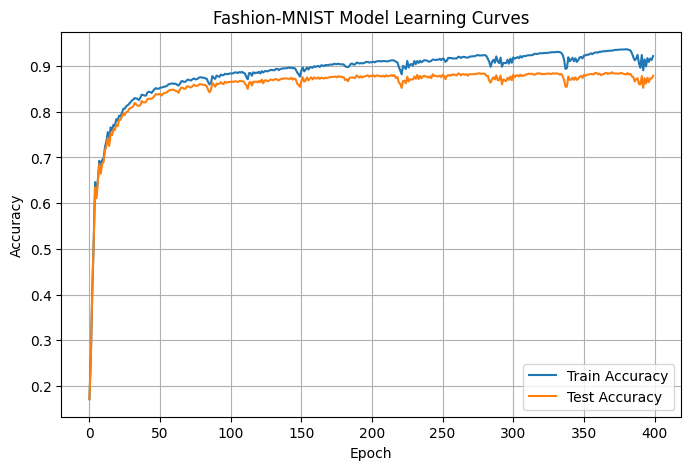

In [ ]:
input_dim_fashion = X_train_fashion.shape[1]
output_dim_fashion = len(torch.unique(y_train_fashion))
hidden_layers_fashion = optimal_params_fashion['hidden_layers']
activation_fashion = optimal_params_fashion['activation']

model_fashion = SimpleMLP(input_dim_fashion, hidden_layers_fashion, output_dim_fashion, activation_fashion).to(device)
optimizer_fashion = torch.optim.Adam(model_fashion.parameters(), lr=optimal_params_fashion['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc = train_model(model_fashion, optimizer_fashion, criterion, X_train_fashion, y_train_fashion, X_test_fashion, y_test_fashion, epochs=400)
plot_learning_curves(train_acc, test_acc, title="Fashion-MNIST Model Learning Curves")

### training for dynamic model

In [ ]:
# take df_cover and build a single data frame for train and test. Have a 70-30 split. 
df_shuffled = df_covtype.sample(frac=1, random_state=42).reset_index(drop=True)
split_idx = int(0.7 * len(df_shuffled))

# Split into train and test
df_train_cov = df_shuffled.iloc[:split_idx]
df_test_cov = df_shuffled.iloc[split_idx:]
df_validation_cov = df_train_cov.sample(frac=0.3, random_state=42).reset_index(drop=True)
df_test_cov = df_test_cov.drop(df_validation_cov.index).reset_index(drop=True)
df_train_cov.head()

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,...,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type,Aspect_sin,Aspect_cos
0,3351.0,27.0,726.0,124.0,3813.0,192.0,252.0,180.0,2271.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,-0.438371,-0.898794
1,2732.0,7.0,212.0,1.0,1082.0,231.0,236.0,137.0,912.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.777146,-0.629320
2,2572.0,9.0,201.0,25.0,957.0,216.0,222.0,142.0,2191.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.406737,0.913545
3,2824.0,13.0,417.0,39.0,3223.0,233.0,214.0,110.0,6478.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.933580,0.358368
4,2529.0,5.0,120.0,9.0,1092.0,227.0,231.0,139.0,4983.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.994522,0.104528


In [ ]:
scaler = StandardScaler()
df_train_cov_scaled = scaler.fit_transform(df_train_cov.drop('Cover_Type', axis=1))
df_test_cov_scaled = scaler.transform(df_test_cov.drop('Cover_Type', axis=1))
df_validation_cov_scaled = scaler.transform(df_validation_cov.drop('Cover_Type', axis=1))

df_train_cov_scaled = pd.DataFrame(df_train_cov_scaled, columns=df_train_cov.drop('Cover_Type', axis=1).columns)
df_train_cov_scaled['label'] = df_train_cov['Cover_Type'].values

df_test_cov_scaled = pd.DataFrame(df_test_cov_scaled, columns=df_test_cov.drop('Cover_Type', axis=1).columns)
df_test_cov_scaled['label'] = df_test_cov['Cover_Type'].values

df_validation_cov_scaled = pd.DataFrame(df_validation_cov_scaled, columns=df_validation_cov.drop('Cover_Type', axis=1).columns)
df_validation_cov_scaled['label'] = df_validation_cov['Cover_Type'].values

print("Covtype train and test DataFrames created.")
print(f"Covtype train shape: {df_train_cov_scaled.shape}, Covtype test shape: {df_test_cov_scaled.shape}, Covtype validation shape: {df_validation_cov_scaled.shape}")
df_train_cov_scaled.head()

Covtype train and test DataFrames created.
Covtype train shape: (406708, 56), Covtype test shape: (174304, 56)


,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,...,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Aspect_sin,Aspect_cos,label
0,1.399803,1.719367,2.150458,1.332765,0.940021,-0.750586,1.450831,0.978161,0.221734,1.108515,...,-0.053181,-0.057409,-0.014114,-0.022566,6.037962,-0.155764,-0.12394,-0.918726,-1.557908,0
1,-0.810529,-0.948668,-0.269226,-0.779925,-0.812549,0.703569,0.641409,-0.144560,-0.806004,-0.902108,...,-0.053181,-0.057409,-0.014114,-0.022566,-0.165619,-0.155764,-0.12394,0.872624,-1.166838,1
2,-1.381859,-0.681865,-0.321009,-0.367693,-0.892765,0.144279,-0.066835,-0.014011,0.161234,-0.902108,...,-0.053181,-0.057409,-0.014114,-0.022566,-0.165619,-0.155764,-0.12394,0.326739,1.072226,1
3,-0.482014,-0.148258,0.695823,-0.127224,0.561399,0.778141,-0.471546,-0.849525,3.403260,1.108515,...,-0.053181,-0.057409,-0.014114,-0.022566,-0.165619,-0.155764,-0.12394,1.103167,0.266532,1
4,-1.535404,-1.215472,-0.702321,-0.642514,-0.806132,0.554425,0.388465,-0.092341,2.272673,1.108515,...,-0.053181,-0.057409,-0.014114,-0.022566,-0.165619,-0.155764,-0.12394,1.192979,-0.101849,1


In [19]:
dfs_cov_all_train = [df_train_cov_scaled[df_train_cov_scaled['label'] == i] for i in range(7)]
dfs_fashion_all_train = [df_train_fashion[df_train_fashion['label'] == i] for i in range(10)]

print("DataFrames split by class created.")

DataFrames split by class created.


In [ ]:
# sort the dataframes list by the size of each dataframe in ascending order
dfs_cov_all_train.sort(key=lambda x: len(x), reverse=False)
sorted_label_order_cov = [df['label'].iloc[0] for df in dfs_cov_all_train]
range_cov = range(0, len(sorted_label_order_cov))
label_map_cov = dict(zip(sorted_label_order_cov, range_cov))


print(f"label order map for covtype: {label_map_cov}")
dfs_cov_all_train = [df.assign(label=label_map_cov[df['label'].iloc[0]]) for df in dfs_cov_all_train]
dfs_cov_all_validation = [df_validation_cov_scaled[df_validation_cov_scaled['label'] == lbl].assign(label=label_map_cov[lbl]) for lbl in sorted_label_order_cov]

print("DataFrames sorted by class size.")
print(f"Size of each class in Covtype train: {[len(df) for df in dfs_cov_all_train]}")
print(f"Label for covtype order: {sorted_label_order_cov}")
print(f"Example entries from class 1 train:\n{dfs_cov_all_train[0].head()} and class 1 test:\n{dfs_cov_all_validation[0].head()}")
print(f"Example entries from class 5 train:\n{dfs_cov_all_train[4].head()} and class 5 test:\n{dfs_cov_all_validation[4].head()}")

label order map for covtype: {np.int32(3): 0, np.int32(4): 1, np.int32(5): 2, np.int32(6): 3, np.int32(2): 4, np.int32(0): 5, np.int32(1): 6}
DataFrames sorted by class size.
Size of each class in Covtype train: [1891, 6734, 12152, 14383, 25236, 148037, 198275]
Label for covtype order: [np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(2), np.int32(0), np.int32(1)]
Example entries from class 1 train:
      Elevation     Slope  Horizontal_Distance_To_Hydrology  \
107   -3.249393  1.319161                         -1.267228   
955   -2.385257  0.385349                          0.516936   
1277  -2.860175  0.918956                         -1.126002   
2102  -2.949445  2.786581                         -0.758812   
2112  -2.824466 -0.014856                         -1.126002   

      Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
107                        -0.797101                        -1.198871   
955                        -0.831454                        

In [ ]:
# Split Fashion-MNIST test set into validation and test sets (50% each)
df_fashion_validation = df_train_fashion.sample(frac=0.3, random_state=42).reset_index(drop=True)
df_test_fashion = df_test_fashion.drop(df_fashion_validation.index).reset_index(drop=True)
print(f"Fashion-MNIST validation shape: {df_fashion_validation.shape}, test shape: {df_test_fashion.shape}")

# sort the dataframes list by the size of each dataframe in ascending order
dfs_fashion_all_train.sort(key=lambda x: len(x), reverse=False)
sorted_label_order_fashion = [df['label'].iloc[0] for df in dfs_fashion_all_train]
range_fashion = range(0, len(sorted_label_order_fashion))
label_map_fashion = dict(zip(sorted_label_order_fashion, range_fashion))

print(f"label order map for fashion: {label_map_fashion}")
# assign the value from the map to the train and test set label
dfs_fashion_all_train = [df.assign(label=label_map_fashion[df['label'].iloc[0]]) for df in dfs_fashion_all_train]
dfs_fashion_all_validation = [df_fashion_validation[df_fashion_validation['label'] == lbl].assign(label=label_map_fashion[lbl]) for lbl in sorted_label_order_fashion]

print("DataFrames sorted by class size.")
print(f"Size of each class in Fashion MNIST train: {[len(df) for df in dfs_fashion_all_train]}")
print(f"Label for fashion order: {sorted_label_order_fashion}")
print(f"Example entries from class 1 train:\n{dfs_fashion_all_train[0].head()} and class 1 validation:\n{dfs_fashion_all_validation[0].head()}")
print(f"Example entries from class 5 train:\n{dfs_fashion_all_train[4].head()} and class 5 validation:\n{dfs_fashion_all_validation[4].head()}")


label order map for fashion: {np.int64(9): 0, np.int64(8): 1, np.int64(7): 2, np.int64(6): 3, np.int64(5): 4, np.int64(4): 5, np.int64(3): 6, np.int64(2): 7, np.int64(1): 8, np.int64(0): 9}
DataFrames sorted by class size.
Size of each class in Fashion MNIST train: [1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]
Label for fashion order: [np.int64(9), np.int64(8), np.int64(7), np.int64(6), np.int64(5), np.int64(4), np.int64(3), np.int64(2), np.int64(1), np.int64(0)]
Example entries from class 1 train:
         0    1    2    3    4    5    6    7    8    9  ...  775  776  777  \
45001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
45003  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
45008  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
45013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
45015  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

      

In [ ]:
def train_complex_model(model, optimizer, criterion, parameters, all_train_dfs, all_test_dfs, label='label', epochs=50):
    device = next(model.parameters()).device
    train_acc = []
    test_acc = []
    look_back = 30

    has_underfit = False
    has_overfit = False
    has_plateaued = False
    lock = False
    lock_epochs = 0

    X_train, y_train, X_test, y_test = None, None, None, None
    current_class_index = 2  # start from the third class since first two are combined initially
    num_plateued = 0
    goal_classes = len(all_train_dfs) - 1  # last valid index
    final_dataset_reached = False
    final_plateau_count = 0
    print(f"Goal classes to achieve (last index): {goal_classes}")

    def combine_new_class_to_dataset(new_class_df_train, new_class_df_test):
        nonlocal X_train, y_train, X_test, y_test
        # new_class_df_* are expected to have the same columns: [feature1,..,featureN, label]
        if X_train is None or y_train is None:
            combined_train_df = new_class_df_train.copy()
            combined_test_df = new_class_df_test.copy()
        else:
            # determine feature column names from the new class df (exclude label)
            feature_cols = list(new_class_df_train.drop(columns=[label]).columns)

            # move tensors to CPU and convert to numpy safely
            Xtr = X_train.detach().cpu().numpy()
            ytr = y_train.detach().cpu().numpy()
            Xte = X_test.detach().cpu().numpy()
            yte = y_test.detach().cpu().numpy()

            # build DataFrames that match the same column layout as new_class_df_train
            train_features = pd.DataFrame(Xtr, columns=feature_cols)
            train_labels = pd.Series(ytr.flatten(), name=label)
            test_features = pd.DataFrame(Xte, columns=feature_cols)
            test_labels = pd.Series(yte.flatten(), name=label)

            existing_train_df = pd.concat([train_features, train_labels], axis=1)
            existing_test_df = pd.concat([test_features, test_labels], axis=1)

            # now append new class rows (axis=0 = rows) and shuffle
            combined_train_df = pd.concat([existing_train_df, new_class_df_train], axis=0).sample(frac=1).reset_index(drop=True)
            combined_test_df = pd.concat([existing_test_df, new_class_df_test], axis=0).sample(frac=1).reset_index(drop=True)

        # convert back to tensors with consistent column ordering
        X_train = torch.tensor(combined_train_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
        y_train = torch.tensor(combined_train_df[label].values, dtype=torch.long).to(device)
        X_test = torch.tensor(combined_test_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
        y_test = torch.tensor(combined_test_df[label].values, dtype=torch.long).to(device)


    combined_train_df = pd.concat(all_train_dfs[:2], axis=0).sample(frac=1).reset_index(drop=True)
    combined_test_df = pd.concat(all_test_dfs[:2], axis=0).sample(frac=1).reset_index(drop=True)

    X_train = torch.tensor(combined_train_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
    y_train = torch.tensor(combined_train_df[label].values, dtype=torch.long).to(device)

    X_test = torch.tensor(combined_test_df.drop(columns=[label]).values, dtype=torch.float32).to(device)
    y_test = torch.tensor(combined_test_df[label].values, dtype=torch.long).to(device)
    print(f"Initial training with classes: {[df[label].iloc[0] for df in all_train_dfs[:2]]}, Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
    epoch = 0

    while epoch < epochs:
        epoch += 1
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Training accuracy
        model.eval()
        with torch.no_grad():
            train_preds = model(X_train).argmax(dim=1)
            test_preds = model(X_test).argmax(dim=1)
            train_acc.append(accuracy_score(y_train.cpu(), train_preds.cpu()))
            test_acc.append(accuracy_score(y_test.cpu(), test_preds.cpu()))

        if epoch > look_back and not lock:
            recent_train_acc = train_acc[-look_back:]
            recent_test_acc = test_acc[-look_back:]

            train_trend = np.polyfit(range(look_back), recent_train_acc, 1)[0]
            test_trend = np.polyfit(range(look_back), recent_test_acc, 1)[0]

            if (train_trend < 0.0001 and test_trend < 0.0001) and num_plateued < 2:
                has_plateaued = True
                num_plateued += 1
                print(f"Training has plateaued at epoch {epoch}.")
                if current_class_index > goal_classes:
                    # we've already added all classes; mark final_dataset_reached and increment final plateau counter
                    final_dataset_reached = True
                    final_plateau_count += 1
                    print("All classes have been added. Continuing training on final dataset.")

            # check if underfitting
            elif train_trend > 0.0005 and test_trend > 0.0001:
                has_underfit = True
                num_plateued = 0
                print(f"Model is underfit at epoch: {epoch}. Adding more neurons class {current_class_index - 1} to the dataset.")
                model.add_hidden_neurons()
                optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'])

            # check if overfitting
            elif (train_trend > 0.01 and test_trend < -0.01) or (num_plateued >= 2):
                has_overfit = True
                num_plateued = 0
                print(f"Model is overfit at epoch: {epoch}. Adding new class {current_class_index} to the dataset.")
                if current_class_index <= goal_classes:
                    print(f"Adding new class {current_class_index} to the dataset.")
                    combine_new_class_to_dataset(all_train_dfs[current_class_index], all_test_dfs[current_class_index])
                    model.update_output_layer(len(torch.unique(y_train)))
                    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'])
                    current_class_index += 1
                    # if we just added the final class, mark it so we treat subsequent plateaus differently
                    if current_class_index > goal_classes:
                        final_dataset_reached = True
                        print("Reached final combined dataset.")
                else:
                    # no more classes to add; continue training on final dataset but avoid repeated triggers
                    print("All classes have been added. Cannot add more classes. Continuing training.")
                    final_dataset_reached = True
                    lock = True
                    lock_epochs = 20
            else:
                print(f"No significant trend detected at epoch {epoch}. Train trend: {train_trend}, Test trend: {test_trend}")

            # if any of the flags are set, lock further checks
            if has_underfit or has_overfit or has_plateaued:
                lock = True
                if has_underfit:
                    lock_epochs = max(lock_epochs, 50)
                else:
                    lock_epochs = max(lock_epochs, 10)
        else:
            if lock:
                lock_epochs -= 1
                if lock_epochs <= 0:
                    lock = False

        # reset flags for next epoch
        has_underfit = False
        has_overfit = False
        has_plateaued = False

        # optional stopping: if final dataset reached and we've seen multiple plateau detections, stop
        if final_dataset_reached and final_plateau_count >= 2:
            print("Final dataset plateaued multiple times — stopping training.")
            break

    print("Training finished. Reached class index:", current_class_index)
    return train_acc, test_acc


In [ ]:
input_dim_cov = X_train_cov.shape[1]
activation_cov = optimal_params_cov['activation']
model_cov_dynamic = DynamicMLP(input_dim_cov).to(device)
optimizer_cov_dynamic = torch.optim.Adam(model_cov_dynamic.parameters(), lr=optimal_params_cov['lr'])
criterion = nn.CrossEntropyLoss()
train_acc, test_acc = train_complex_model(model_cov_dynamic, optimizer_cov_dynamic, criterion, optimal_params_cov, dfs_cov_all_train, dfs_cov_all_validation, epochs=1000)
plot_learning_curves(train_acc, test_acc, title="Dynamic Covtype Model Learning Curves")
model_cov_dynamic.print_structure()

Goal classes to achieve: 7
Initial training with classes: [np.int64(0), np.int64(1)], Train size: 8625, Test size: 3615
Model is underfit at epoch: 21. Adding more neurons class 1 to the dataset.
Added neurons to layer 0, new size: 2
Output layer updated to 2 -> 2
Training has plateaued at epoch 32.
Training has plateaued at epoch 43.
Model is overfit at epoch: 54. Adding new class 2 to the dataset.
Adding new class 2 to the dataset.
Training has plateaued at epoch 65.
Training has plateaued at epoch 76.
Model is overfit at epoch: 87. Adding new class 3 to the dataset.
Adding new class 3 to the dataset.
Training has plateaued at epoch 98.
Model is underfit at epoch: 109. Adding more neurons class 3 to the dataset.
Added neurons to layer 0, new size: 4
Output layer updated to 4 -> 4
Model is underfit at epoch: 120. Adding more neurons class 3 to the dataset.
Added neurons to layer 0, new size: 8
Output layer updated to 8 -> 4
Model is underfit at epoch: 131. Adding more neurons class 3 

KeyboardInterrupt: 

### Evaluation of baseline models and dynamic models

In [ ]:
runs = 3
results = {
    'baseline': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []},
    'dynamic': {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}
}

# Use existing dataset arrays and DataFrames available in the notebook
feature_cols_cov = df_covtype.drop('Cover_Type', axis=1).columns
num_classes_cov = len(df_covtype['Cover_Type'].unique())

input_dim = None
output_dim = None
hidden_layers = optimal_params_cov['hidden_layers']
activation = optimal_params_cov['activation']
lr = optimal_params_cov['lr']
epochs = 200  # per-run training epochs for baseline; dynamic will use same value for max epochs

for run in range(runs):
    print(f"Run {run+1}/{runs}")
    # different seed for different train/validation splits
    seed = 42 + run

    # --- Prepare per-run Covtype splits and scalers ---
    X_train_cov_init, X_test_cov_init, y_train_cov_init, y_test_cov_init = train_test_split(
        X_cov_type, y_cov_type, test_size=0.3, random_state=seed)
    X_train_cov_final, X_validation_cov_final, y_train_cov_final, y_validation_cov_final = train_test_split(
        X_train_cov_init, y_train_cov_init, test_size=0.3, random_state=seed)

    scaler = StandardScaler()
    X_train_cov_scaled = scaler.fit_transform(X_train_cov_final)
    X_validation_cov_scaled = scaler.transform(X_validation_cov_final)

    # build per-run DataFrames (same format as the rest of the notebook)
    df_train_cov_run = pd.DataFrame(X_train_cov_scaled, columns=feature_cols_cov)
    df_train_cov_run['label'] = y_train_cov_final
    df_validation_cov_run = pd.DataFrame(X_validation_cov_scaled, columns=feature_cols_cov)
    df_validation_cov_run['label'] = y_validation_cov_final

    # create per-class lists required by the dynamic training routine
    dfs_cov_all_train_run = [df_train_cov_run[df_train_cov_run['label'] == i].copy() for i in range(num_classes_cov)]
    dfs_cov_all_validation_run = [df_validation_cov_run[df_validation_cov_run['label'] == i].copy() for i in range(num_classes_cov)]

    # sort classes by size and relabel (keeps same logic as earlier in the notebook)
    dfs_cov_all_train_run.sort(key=lambda x: len(x), reverse=False)
    sorted_label_order_cov = [int(df['label'].iloc[0]) if len(df) > 0 else -1 for df in dfs_cov_all_train_run]
    # filter out empty classes (if any) and create mapping
    non_empty = [lbl for lbl in sorted_label_order_cov if lbl != -1]
    label_map_cov = dict(zip(non_empty, range(len(non_empty))))
    dfs_cov_all_train_run = [df.assign(label=label_map_cov[df['label'].iloc[0]]) for df in dfs_cov_all_train_run if len(df) > 0]
    dfs_cov_all_validation_run = [df_validation_cov_run[df_validation_cov_run['label'] == lbl].assign(label=label_map_cov[lbl]) for lbl in non_empty]

    # create tensors for baseline training / validation
    X_train_cov_run = torch.tensor(df_train_cov_run.drop(columns=['label']).values, dtype=torch.float32).to(device)
    y_train_cov_run = torch.tensor(df_train_cov_run['label'].values, dtype=torch.long).to(device)
    X_validation_cov_run = torch.tensor(df_validation_cov_run.drop(columns=['label']).values, dtype=torch.float32).to(device)
    y_validation_cov_run = torch.tensor(df_validation_cov_run['label'].values, dtype=torch.long).to(device)

    input_dim = X_train_cov_run.shape[1]
    output_dim = len(torch.unique(y_train_cov_run))

    # --- Baseline SimpleMLP trained on per-run tensors ---
    baseline_model = SimpleMLP(input_dim, hidden_layers, output_dim, activation).to(device)
    opt_b = torch.optim.Adam(baseline_model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()

    t0 = time.time()
    baseline_model.train()
    for ep in range(epochs):
        opt_b.zero_grad()
        out = baseline_model(X_train_cov_run)
        loss = crit(out, y_train_cov_run)
        loss.backward()
        opt_b.step()
    t1 = time.time()

    baseline_model.eval()
    with torch.no_grad():
        val_preds = baseline_model(X_validation_cov_run).argmax(dim=1)
        acc = accuracy_score(y_validation_cov_run.cpu(), val_preds.cpu())
        prec = precision_score(y_validation_cov_run.cpu(), val_preds.cpu(), average='weighted', zero_division=0)
        rec = recall_score(y_validation_cov_run.cpu(), val_preds.cpu(), average='weighted', zero_division=0)
        f1 = f1_score(y_validation_cov_run.cpu(), val_preds.cpu(), average='weighted', zero_division=0)

    results['baseline']['accuracy'].append(acc)
    results['baseline']['precision'].append(prec)
    results['baseline']['recall'].append(rec)
    results['baseline']['f1'].append(f1)
    results['baseline']['time'].append(t1 - t0)

    print(f"Baseline run {run+1}: val_acc={acc:.4f}, prec={prec:.4f}, recall={rec:.4f}, f1={f1:.4f}, time={t1-t0:.2f}s")

    # --- Dynamic model using per-run per-class DataFrames ---
    dyn_model = DynamicMLP(input_dim).to(device)
    opt_d = torch.optim.Adam(dyn_model.parameters(), lr=lr)

    t0 = time.time()
    # train_complex_model will operate on per-class DataFrames
    train_acc_list, val_acc_list = train_complex_model(
        dyn_model, opt_d, crit, optimal_params_cov,
        dfs_cov_all_train_run, dfs_cov_all_validation_run,
        label='label', epochs=epochs
    )
    t1 = time.time()

    # evaluate dynamic model on the same validation tensors
    dyn_model.eval()
    with torch.no_grad():
        val_preds_d = dyn_model(X_validation_cov_run).argmax(dim=1)
        acc_d = accuracy_score(y_validation_cov_run.cpu(), val_preds_d.cpu())
        prec_d = precision_score(y_validation_cov_run.cpu(), val_preds_d.cpu(), average='weighted', zero_division=0)
        rec_d = recall_score(y_validation_cov_run.cpu(), val_preds_d.cpu(), average='weighted', zero_division=0)
        f1_d = f1_score(y_validation_cov_run.cpu(), val_preds_d.cpu(), average='weighted', zero_division=0)

    results['dynamic']['accuracy'].append(acc_d)
    results['dynamic']['precision'].append(prec_d)
    results['dynamic']['recall'].append(rec_d)
    results['dynamic']['f1'].append(f1_d)
    results['dynamic']['time'].append(t1 - t0)

    print(f"Dynamic run {run+1}: val_acc={acc_d:.4f}, prec={prec_d:.4f}, recall={rec_d:.4f}, f1={f1_d:.4f}, time={t1-t0:.2f}s")
    print("---")

# End runs
print('\nAll runs complete.')


In [ ]:
# Ensure results directory exists
os.makedirs(results_dir, exist_ok=True)

# build summary DataFrame
rows = []
for model_name in ['baseline', 'dynamic']:
    row = {'model': model_name}
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'time']:
        vals = results[model_name][metric]
        row[f'{metric}_mean'] = np.mean(vals) if len(vals) > 0 else np.nan
        row[f'{metric}_std'] = np.std(vals, ddof=1) if len(vals) > 1 else 0.0
    rows.append(row)

summary_df = pd.DataFrame(rows)
# nicer ordering
cols = ['model'] + [c for m in ['accuracy', 'precision', 'recall', 'f1', 'time'] for c in (f'{m}_mean', f'{m}_std')]
summary_df = summary_df[cols]
print('\nCross-validation summary (means and std):')
print(summary_df)

# Save per-run results and summary to CSV
per_run_rows = []
for model_name in ['baseline', 'dynamic']:
    for i in range(len(results[model_name]['accuracy'])):
        per_run_rows.append({
            'model': model_name,
            'run': i+1,
            'accuracy': results[model_name]['accuracy'][i],
            'precision': results[model_name]['precision'][i],
            'recall': results[model_name]['recall'][i],
            'f1': results[model_name]['f1'][i],
            'time': results[model_name]['time'][i]
        })
per_run_df = pd.DataFrame(per_run_rows)
per_run_csv = os.path.join(results_dir, 'evaluation_per_run.csv')
per_run_df.to_csv(per_run_csv, index=False)
print(f"Per-run results saved to: {per_run_csv}")

summary_csv = os.path.join(results_dir, 'evaluation_summary.csv')
summary_df.to_csv(summary_csv, index=False)
print(f"Summary saved to: {summary_csv}")

# Also append to a master evaluation file (creates if not present)
master_csv = os.path.join(results_dir, 'evaluation_results.csv')
# create master file with headers if it doesn't exist
if not os.path.exists(master_csv):
    summary_df.to_csv(master_csv, index=False)
else:
    # append with a header only if file is empty
    summary_df.to_csv(master_csv, mode='a', header=False, index=False)
print(f"Appended summary to master file: {master_csv}")

# Final classification reports on the shared TEST set
print('\nClassification reports on shared TEST set:')
# Baseline final model: retrain baseline on full training+validation (to make final test evaluation fair)
print('\nRetraining baseline on train+validation and evaluating on TEST set...')
# combine training and validation into one set (use last run's splits as representative)
X_full_train = torch.cat([X_train_cov_run, X_validation_cov_run], dim=0)
Y_full_train = torch.cat([y_train_cov_run, y_validation_cov_run], dim=0)

final_baseline = SimpleMLP(input_dim, hidden_layers, output_dim, activation).to(device)
opt_fb = torch.optim.Adam(final_baseline.parameters(), lr=lr)
final_baseline.train()
for ep in range(epochs):
    opt_fb.zero_grad()
    out = final_baseline(X_full_train)
    loss = crit(out, Y_full_train)
    loss.backward()
    opt_fb.step()
final_baseline.eval()
with torch.no_grad():
    test_preds_b = final_baseline(X_test_cov).argmax(dim=1)
print('\nBaseline TEST classification report:')
report_b = classification_report(y_test_cov.cpu(), test_preds_b.cpu(), zero_division=0, output_dict=True)
print(classification_report(y_test_cov.cpu(), test_preds_b.cpu(), zero_division=0))

# save baseline report
baseline_report_file = os.path.join(results_dir, 'baseline_test_classification_report.json')
with open(baseline_report_file, 'w') as f:
    json.dump(report_b, f, indent=2)
print(f"Baseline test classification report saved to: {baseline_report_file}")


In [ ]:
# Dynamic final model: retrain with train_complex_model on dfs_cov_all_train + dfs_cov_all_validation (the splits already used), then evaluate on same X_test_cov
print('\nTraining dynamic model on train+validation (per-class) and evaluating on TEST set...')
final_dynamic = DynamicMLP(input_dim).to(device)
opt_fd = torch.optim.Adam(final_dynamic.parameters(), lr=lr)
# train using the per-run per-class data we created earlier (dfs_cov_all_train_run/validation)
train_complex_model(final_dynamic, opt_fd, crit, optimal_params_cov, dfs_cov_all_train_run, dfs_cov_all_validation_run, label='label', epochs=epochs)
final_dynamic.eval()
with torch.no_grad():
    test_preds_d = final_dynamic(X_test_cov).argmax(dim=1)
print('\nDynamic TEST classification report:')
report_d = classification_report(y_test_cov.cpu(), test_preds_d.cpu(), zero_division=0, output_dict=True)
print(classification_report(y_test_cov.cpu(), test_preds_d.cpu(), zero_division=0))

# save dynamic report
dynamic_report_file = os.path.join(results_dir, 'dynamic_test_classification_report.json')
with open(dynamic_report_file, 'w') as f:
    json.dump(report_d, f, indent=2)
print(f"Dynamic test classification report saved to: {dynamic_report_file}")

# Append a combined row to master CSV with timestamps and paths for artifacts
timestamp = pd.Timestamp.now().isoformat()
combined_row = {
    'timestamp': timestamp,
    'dataset': 'covtype',
    'runs': runs,
    'baseline_summary_path': summary_csv,
    'per_run_path': per_run_csv,
    'baseline_report': baseline_report_file,
    'dynamic_report': dynamic_report_file
}
combined_df = pd.DataFrame([combined_row])
master_meta_csv = os.path.join(results_dir, 'evaluation_runs_meta.csv')
if not os.path.exists(master_meta_csv):
    combined_df.to_csv(master_meta_csv, index=False)
else:
    combined_df.to_csv(master_meta_csv, mode='a', header=False, index=False)
print(f"Evaluation metadata appended to: {master_meta_csv}")


In [ ]:
Summary_df